In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [3]:
sns.set(style="whitegrid", context="notebook")

In [4]:
df = pd.read_csv("../datos/comentarios.csv")
textos = df["texto_comentario"].astype(str).tolist()

In [5]:
modelo = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
embeddings = modelo.encode(textos, show_progress_bar=True)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\maria\.cache\huggingface\hub\models--sentence-transformers--paraphrase-multilingual-MiniLM-L12-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.wa

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

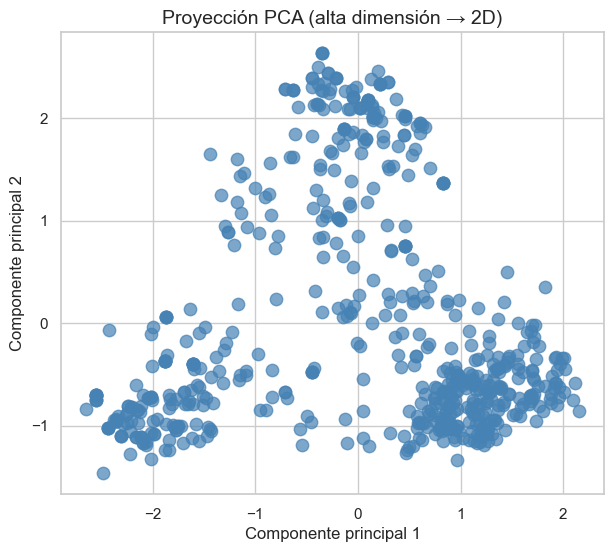

In [6]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

plt.figure(figsize=(7, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], s=80, alpha=0.7, color="steelblue")
plt.title("Proyección PCA (alta dimensión → 2D)", fontsize=14)
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.show()

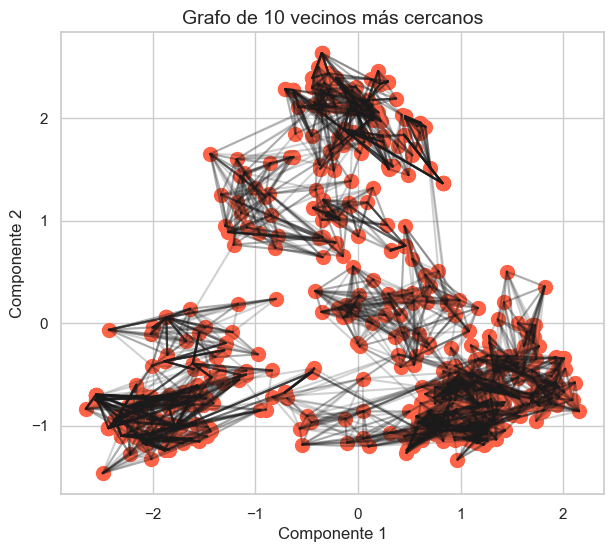

In [7]:
n_neighbors = 10
nn = NearestNeighbors(n_neighbors=n_neighbors, metric="cosine")
nn.fit(embeddings)
distances, indices = nn.kneighbors(embeddings)

# Mostrar conexiones entre puntos
plt.figure(figsize=(7, 6))
for i in range(len(indices)):
    for j in indices[i][1:]:
        plt.plot([pca_result[i, 0], pca_result[j, 0]],
                 [pca_result[i, 1], pca_result[j, 1]], "k-", alpha=0.2)
plt.scatter(pca_result[:, 0], pca_result[:, 1], s=100, color="tomato")
plt.title(f"Grafo de {n_neighbors} vecinos más cercanos", fontsize=14)
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()

C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


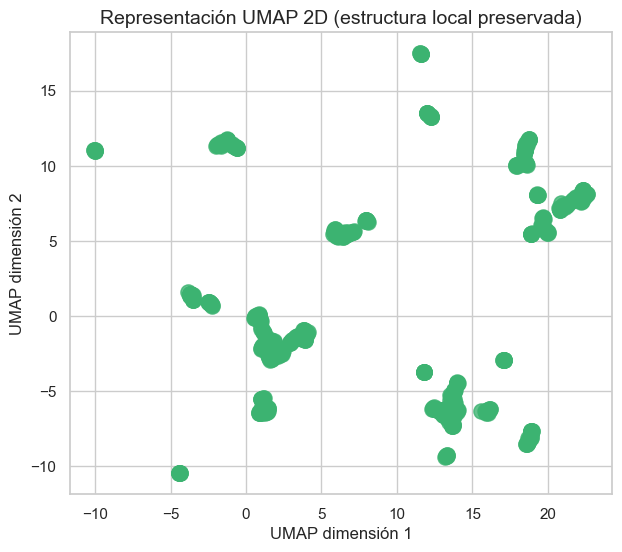

In [8]:
umap_model = umap.UMAP(
    n_neighbors=20,
    n_components=2,
    metric='cosine',
    random_state=42
).fit(embeddings)

umap_2d = umap_model.embedding_

plt.figure(figsize=(7, 6))
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], s=120, alpha=0.8, color="mediumseagreen")
plt.title("Representación UMAP 2D (estructura local preservada)", fontsize=14)
plt.xlabel("UMAP dimensión 1")
plt.ylabel("UMAP dimensión 2")
plt.show()

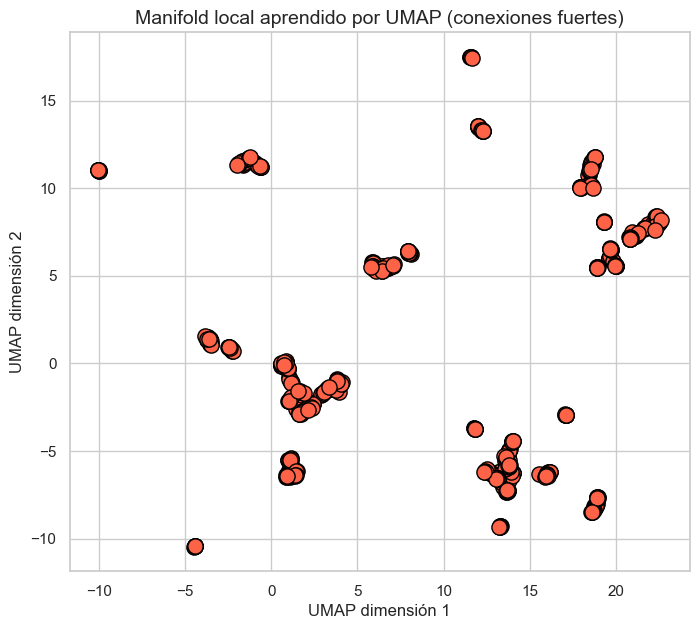

In [10]:
import numpy as np

rows, cols = umap_model.graph_.nonzero()
weights = umap_model.graph_.data

# Normalizamos pesos y filtramos los más fuertes
threshold = np.percentile(weights, 97)
strong_edges = (weights > threshold)

plt.figure(figsize=(8, 7))
for i, j, w in zip(rows[strong_edges], cols[strong_edges], weights[strong_edges]):
    plt.plot(
        [umap_2d[i, 0], umap_2d[j, 0]],
        [umap_2d[i, 1], umap_2d[j, 1]],
        color='lightgray', alpha=0.3, linewidth=0.8
    )

plt.scatter(umap_2d[:, 0], umap_2d[:, 1], s=120, c='tomato', edgecolor='black')
plt.title("Manifold local aprendido por UMAP (conexiones fuertes)", fontsize=14)
plt.xlabel("UMAP dimensión 1")
plt.ylabel("UMAP dimensión 2")
plt.show()

In [13]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15,
    metric='euclidean',
    cluster_selection_method='eom'
).fit(umap_2d)

df["cluster"] = clusterer.labels_
df["probabilidad"] = clusterer.probabilities_

df.head()

C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,id_comentario,id_cliente,id_producto,calificacion,texto_comentario,fecha_comentario,cluster,probabilidad
0,1,1,2,5,El Smartphone Nexus 5G es un cambio de juego. ...,2024-05-20,8,1.000000
1,2,2,4,4,La Camiseta Deportiva Ultralight es muy cómoda...,2024-05-21,9,0.386196
2,3,3,1,5,La Laptop Gamer Pro es una bestia de rendimien...,2024-05-22,4,1.000000
3,4,4,5,3,Las Zapatillas Urbanas Fit tienen un diseño mu...,2024-05-23,12,0.882428
4,5,5,3,4,Los Auriculares Inalámbricos X ofrecen un soni...,2024-05-24,1,1.000000


C:\Users\maria\AppData\Local\Temp\ipykernel_29828\107155654.py:4: UserWarning: 
The palette list has fewer values (14) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(
C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


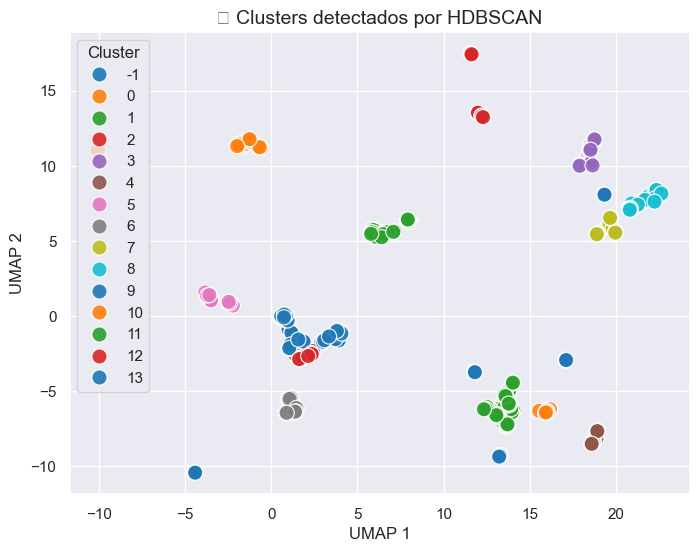

In [14]:
palette = sns.color_palette("tab10", len(set(df["cluster"])) - (1 if -1 in df["cluster"].unique() else 0))

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=umap_2d[:, 0],
    y=umap_2d[:, 1],
    hue=df["cluster"],
    palette=palette,
    s=120,
    alpha=0.9,
    legend="full"
)
plt.title("🧩 Clusters detectados por HDBSCAN", fontsize=14)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cluster")
plt.show()


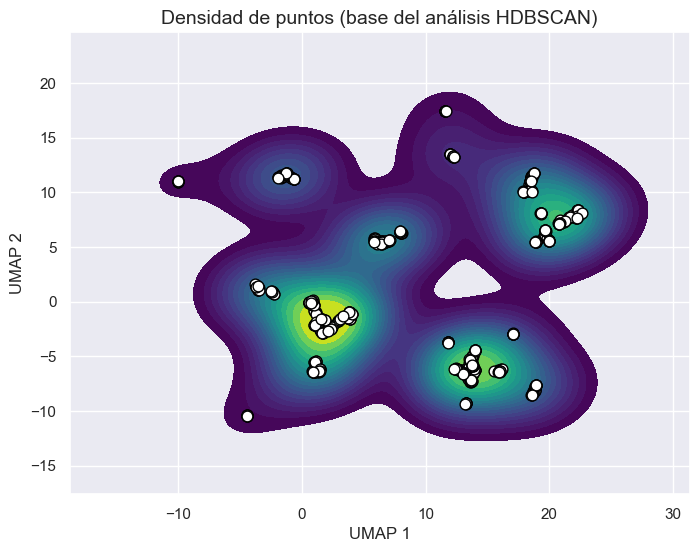

In [15]:
plt.figure(figsize=(8, 6))
sns.kdeplot(x=umap_2d[:, 0], y=umap_2d[:, 1], fill=True, cmap="viridis", levels=20)
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], s=60, color="white", edgecolor="black")
plt.title("Densidad de puntos (base del análisis HDBSCAN)", fontsize=14)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

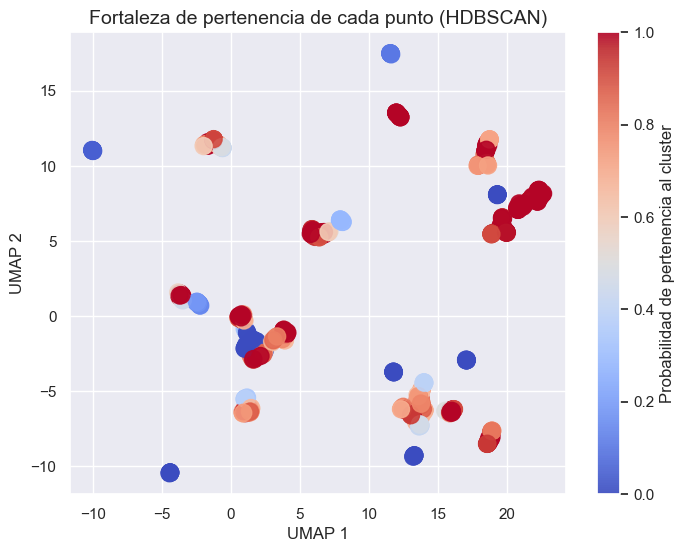

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(
    umap_2d[:, 0],
    umap_2d[:, 1],
    c=df["probabilidad"],
    cmap="coolwarm",
    s=150,
    alpha=0.9
)
plt.colorbar(label="Probabilidad de pertenencia al cluster")
plt.title("Fortaleza de pertenencia de cada punto (HDBSCAN)", fontsize=14)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

In [17]:
!python -m spacy download es_core_news_sm

Traceback (most recent call last):
  File "C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\confection\__init__.py", line 38, in <module>
    from pydantic.v1 import BaseModel, Extra, ValidationError, create_model
  File "C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pydantic\__init__.py", line 5, in <module>
    from ._migration import getattr_migration
  File "C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pydantic\_migration.py", line 4, in <module>
    from pydantic.warnings import PydanticDeprecatedSince20
  File "C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pydantic\warnings.py", line 5, in <module>
    from .version 

In [48]:
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [49]:
nlp = spacy.load("es_core_news_sm")
stopwords = list(nlp.Defaults.stop_words)

docs = df[df["cluster"] != -1]

cluster_docs = docs.groupby("cluster")["texto_comentario"].apply(lambda x: " ".join(x)).reset_index()

vectorizer = CountVectorizer(stop_words=stopwords)
X_counts = vectorizer.fit_transform(cluster_docs["texto_comentario"])

tfidf_transformer = TfidfTransformer(norm=None, use_idf=True, smooth_idf=True)
X_ctfidf = tfidf_transformer.fit_transform(X_counts)

terms = vectorizer.get_feature_names_out()
for i, topic_vector in enumerate(X_ctfidf.toarray()):
    top_indices = topic_vector.argsort()[-10:][::-1]
    top_terms = [terms[idx] for idx in top_indices]
    print(f"\nCluster {cluster_docs.iloc[i]['cluster']} — Palabras clave:")
    print(", ".join(top_terms))


🧩 Cluster 0 — Palabras clave:
trama, personajes, historia, libro, lectura, costó, interesante, entretenida, escritura, confusa

🧩 Cluster 1 — Palabras clave:
material, mochila, suela, camiseta, cómodas, puerto, siente, zapatillas, funcional, usb

🧩 Cluster 2 — Palabras clave:
balón, durabilidad, agarre, rebote, consistente, control, desgastó, costura, top, diseño

🧩 Cluster 3 — Palabras clave:
ollas, cocina, comida, set, fáciles, limpiar, calor, calidad, uniforme, acabado

🧩 Cluster 4 — Palabras clave:
sonido, auriculares, audio, micrófono, ruido, cancelación, calidad, batería, dura, música

🧩 Cluster 5 — Palabras clave:
acción, estabilización, 4k, cámara, perfecta, video, maravilla, calidad, fácil, asombrosa

🧩 Cluster 6 — Palabras clave:
estabilización, cámara, video, calidad, grabar, perfecta, carcasa, resistente, batería, fácil

🧩 Cluster 7 — Palabras clave:
gamer, pro, laptop, potente, máquina, teclado, gráfica, tarjeta, bestia, procesador

🧩 Cluster 8 — Palabras clave:
cámara, b

/Users/erichuiza/Documents/pucp/miería web/dev/sesion-de-clase-07/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/erichuiza/Documents/pucp/miería web/dev/sesion-de-clase-07/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


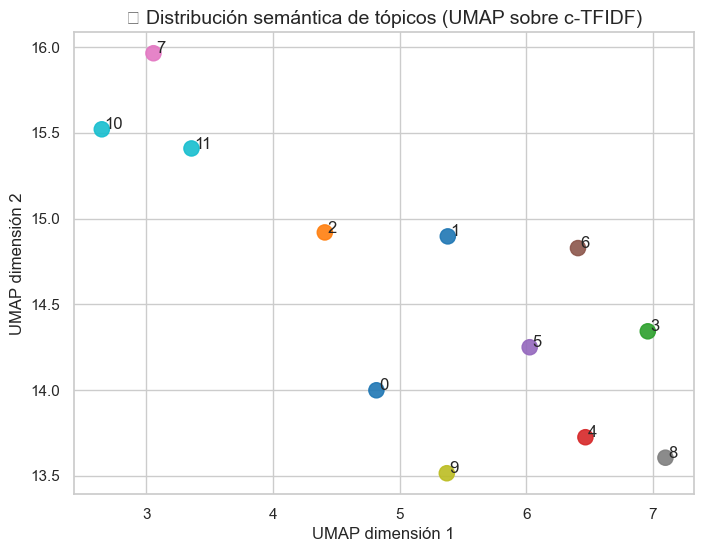

In [50]:
import umap
import matplotlib.pyplot as plt

# Reducimos la matriz c-TFIDF (tópicos x términos) a 2D
umap_model = umap.UMAP(
    n_neighbors=5,
    n_components=2,
    metric='cosine',
    random_state=42
)
embedding_ctfidf = umap_model.fit_transform(X_ctfidf.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(
    embedding_ctfidf[:, 0],
    embedding_ctfidf[:, 1],
    s=120,
    c=cluster_docs["cluster"],
    cmap="tab10",
    alpha=0.9
)
for i, txt in enumerate(cluster_docs["cluster"]):
    plt.text(embedding_ctfidf[i, 0] + 0.02, embedding_ctfidf[i, 1], str(txt), fontsize=12)

plt.title("Distribución semántica de tópicos (UMAP sobre c-TFIDF)", fontsize=14)
plt.xlabel("UMAP dimensión 1")
plt.ylabel("UMAP dimensión 2")
plt.show()

/Users/erichuiza/Documents/pucp/miería web/dev/sesion-de-clase-07/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9729 (\N{CLOUD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/erichuiza/Documents/pucp/miería web/dev/sesion-de-clase-07/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


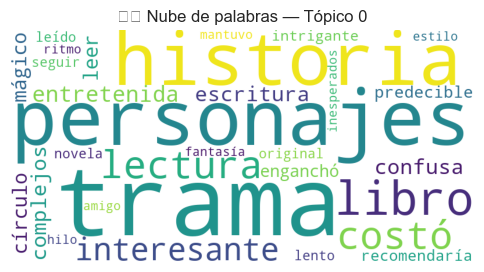

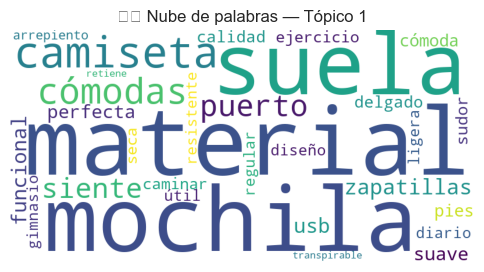

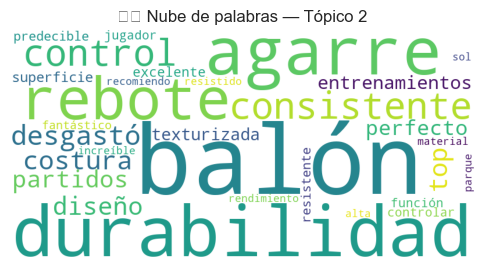

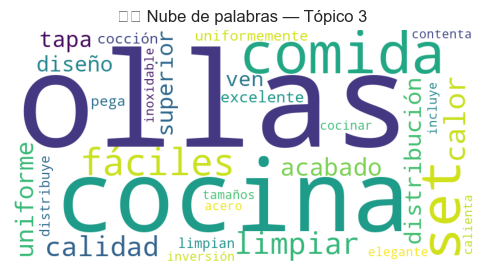

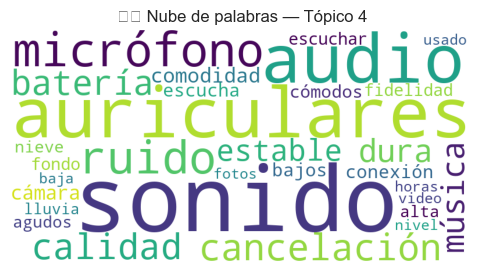

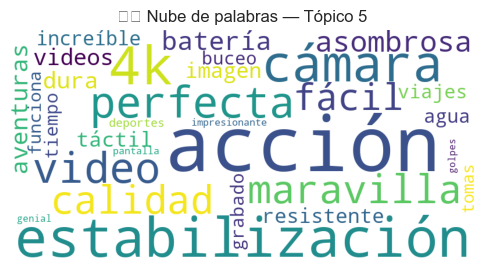

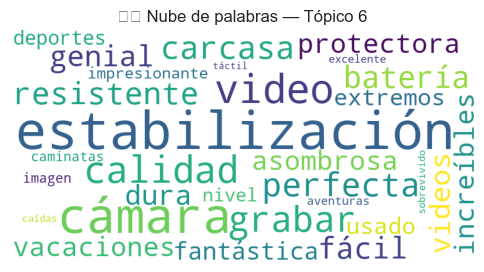

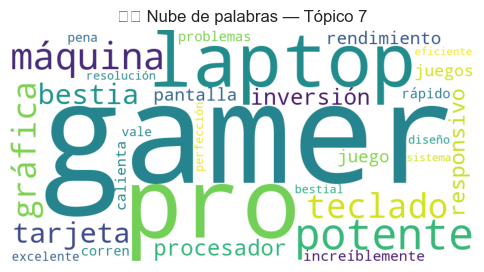

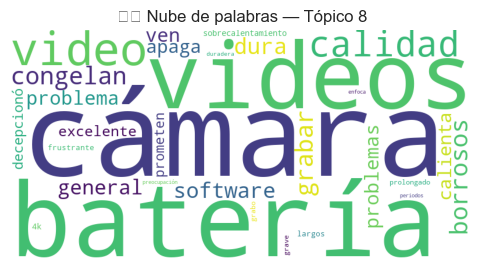

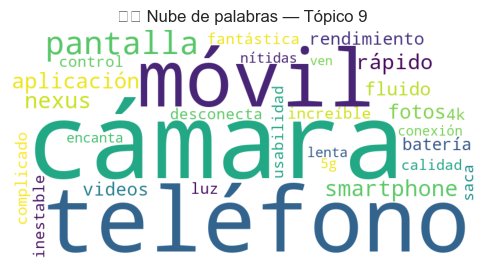

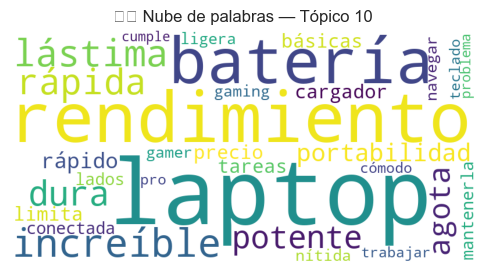

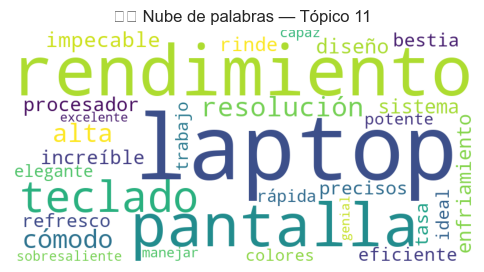

In [51]:
from wordcloud import WordCloud

for i, topic_vector in enumerate(X_ctfidf.toarray()):
    top_indices = topic_vector.argsort()[-30:][::-1]
    top_terms = {terms[idx]: topic_vector[idx] for idx in top_indices}

    plt.figure(figsize=(6, 4))
    plt.imshow(WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(top_terms))
    plt.axis("off")
    plt.title(f"☁️ Nube de palabras — Tópico {cluster_docs.iloc[i]['cluster']}")
    plt.show()